In [10]:
from __future__ import division
import imageio
import numpy as np
import scipy as sp
import scipy.fftpack as ft
import PIL
import cv2
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['gray']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


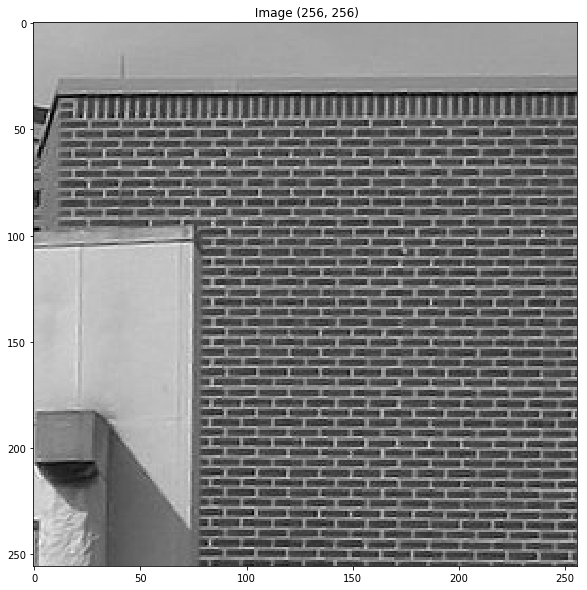

In [15]:
import imageio as imio
image = imio.imread('Moire.jpg')
n = 0
image = np.sum(image*[0.21, 0.72 , 0.07], axis=-1) #grayscale
plt.figure(figsize = (10,10))
cropped = image[n : n + 256, n : n + 256] #cropping
plt.title(" Image " + str(np.shape(cropped)))
plt.gray()
plt.imshow(cropped)

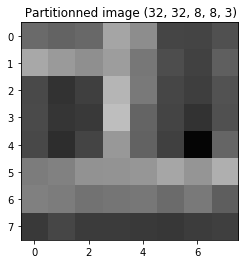

In [27]:
# Step 1 : divide in 8x8 matrixes (optional)
def tile_image(cropped) : 
    divided = np.array((cropped.shape[0] // 8) * [(cropped.shape[1] // 8) * [np.zeros((8, 8, 3))]])
    for i in range(cropped.shape[0]):
        for j in range(cropped.shape[1]):
            divided[i//8][j//8][i % 8][j % 8] = cropped[i][j]
            # Step 2 : Normalize : cropped[i][j] - 128
            #print(i//8, j//8, i % 8, j % 8)
    return divided
tiled = tile_image(cropped)       
plt.title(" Partitionned image " + str(np.shape(tiled)))
plt.imshow(tiled[5][2].astype('uint8'))

In [32]:
"""from PIL import Image
img = Image.open('Moire.jpg')
img_yuv = img.convert('YCbCr')

image = asarray(img_yuv)
n = 120
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
cropped_yuv = image[n:n+256,n:n + 256]
plt.title(" Image " + str(np.shape(cropped_yuv)))

plt.imshow(cropped_yuv)"""

'from PIL import Image\nimg = Image.open(\'Moire.jpg\')\nimg_yuv = img.convert(\'YCbCr\')\n\nimage = asarray(img_yuv)\nn = 120\nplt.figure(figsize = (10,10))\nplt.subplot(1,2,1)\ncropped_yuv = image[n:n+256,n:n + 256]\nplt.title(" Image " + str(np.shape(cropped_yuv)))\n\nplt.imshow(cropped_yuv)'

In [34]:
# Step 2 (useless in the case of grayscaled image) : Convert to YUV
def RGBtoYUV(px):
    R = px[0]
    G = px[1]
    B = px[2]
    Y = 0.299 * R + 0.587 * G + 0.114 * B
    U = -0.14713 * R - 0.28886 * G + 0.436 * B
    V = 0.615*R - 0.51498 * G - 0.10001 * B
    
    return [Y, U, V]

def YUVtoRGB(px):
    Y = px[0];
    U = px[1];
    V = px[2];
    R = Y + 1.13983 * V
    G = Y - 0.39465 * U - 0.58060 * V
    B = Y + 2.03211 * U
    
    return [R, G, B]

def matRGBtoYUV(mat):
    for i in range(8):
        for j in range(8):
            mat[i][j] = RGBtoYUV(mat[i][j])
            
def matYUVtoRGB(mat):
    for i in range(8):
        for j in range(8):
            mat[i][j] = YUVtoRGB(mat[i][j])

for i in range(divided.shape[0]):
    for j in range(divided.shape[1]):
        matRGBtoYUV(divided[i][j])

"""plt.subplot(1, 2, 1)        
plt.imshow(divided[3][4].astype('uint8'))
        
for i in range(divided.shape[0]):
    for j in range(divided.shape[1]):
        matYUVtoRGB(divided[i][j])
plt.subplot(1, 2, 2)     
plt.imshow(divided[3][4].astype('uint8'))"""

"plt.subplot(1, 2, 1)        \nplt.imshow(divided[3][4].astype('uint8'))\n        \nfor i in range(divided.shape[0]):\n    for j in range(divided.shape[1]):\n        matYUVtoRGB(divided[i][j])\nplt.subplot(1, 2, 2)     \nplt.imshow(divided[3][4].astype('uint8'))"

In [37]:
# Step 3 : DWT

def subsampling(x, d):
    p = 2
    if d == 0:
        y = x[::p, :]
    elif d == 1:
        y = x[:, ::p]
    return y

# Below is a circular convolution implemented. 
def cconv(x, h, d):
    if d == 1:
        return np.transpose(cconv(np.transpose(x), h, 0))
    y = np.zeros(x.shape)
    p = len(h)
    pc = int(round( float((p - 1) / 2 )))
    for i in range(0, p):
        y = y + h[i] * np.roll(x, pc-i, axis=0)
    return y

h = [0, .482962913145, .836516303738, .224143868042, -.129409522551]
h = h/norm(h) ## make sure the filter has norm 1.
u = power(-ones(len(h)-1),range(1,len(h))) # alternate +1/-1
g = concatenate(([0], h[-1:0:-1] * u))
print("low-pass filter associated with the scaling function",h)
print("high-pass filter associated with the wavelet function",g)

low-pass filter associated with the scaling function [ 0.          0.48296291  0.8365163   0.22414387 -0.12940952]
high-pass filter associated with the wavelet function [ 0.          0.12940952  0.22414387 -0.8365163   0.48296291]


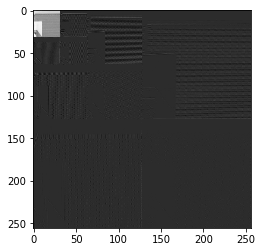

In [38]:
#Step 3 : Wavelet transform
def coarse(image,d):
    # d is the dimension along which the operation is performed.
    # the formula to be implemented is the convolution of x by h along the dimension d.
    return subsampling(cconv(image, h, d), d) #filtre passe bas sur l'image

def fine(image,d):
    # d is the dimension along which the operation is performed.
    # the formula to be implemented is the convolution of x by g along the dimension d.
    return subsampling(cconv(image, g, d), d) #filtre passe haut sur l'image

def W_0(image,wavelet_coeff=None):
    # start with the first dimension index 0 to get coarse and fine description along this axis
    
    # process again the previous results to get coarse and fine description along the axis of index 1.
    # you thus should have 4 sub-images of the same size which is the initial image size divided by 4 (divide columns and rows by 2).
    
    # concatenate your results in an array called results
    c = coarse(image, 0)
    f = fine(image, 0)
    
    cc = coarse(c, 1)
    cf = coarse(f, 1)
    fc = fine(c, 1)
    ff = fine(f, 1)
    
    res1 = concatenate([cc, fc], axis = 0)
    res2 = concatenate([cf, ff], axis = 0)
    return concatenate([res1, res2], axis = 1)
    

def WaveletTransform(image,iterations =1):
    ## iterate the 1step wavelet transform implemented above.
    if iterations == 0 :
        return image
    
    half = shape(image)[0] // 2
    
    w0 = W_0(image)
    LL = w0[:half, :half]
    LH = w0[:half, half:]
    HL = w0[half:, :half]
    HH = w0[half:, half:]
    
    LL = WaveletTransform(LL, iterations - 1)
    
    res1 = np.concatenate([LL, HL], axis = 0)
    res2 = np.concatenate([LH, HH], axis = 0)
    return np.concatenate([res1, res2], axis = 1)

it = 3
Wt = WaveletTransform(cropped, it)
plt.imshow(Wt)

array([[0.5547598 , 0.90440278, 0.86723113, ..., 0.43911796, 0.44328518,
        0.43712192],
       [0.75964553, 0.82869282, 0.8312379 , ..., 0.5018702 , 0.5       ,
        0.50013427],
       [0.74743339, 0.81554816, 0.81237824, ..., 0.49837483, 0.49742174,
        0.49986879],
       ...,
       [0.58850076, 0.34411558, 0.55622281, ..., 0.41209679, 0.51733123,
        0.52926962],
       [0.57438018, 0.34537052, 0.54301206, ..., 0.58119638, 0.56183291,
        0.44836875],
       [0.61718796, 0.37693558, 0.48091877, ..., 0.46850722, 0.43505625,
        0.39849456]])

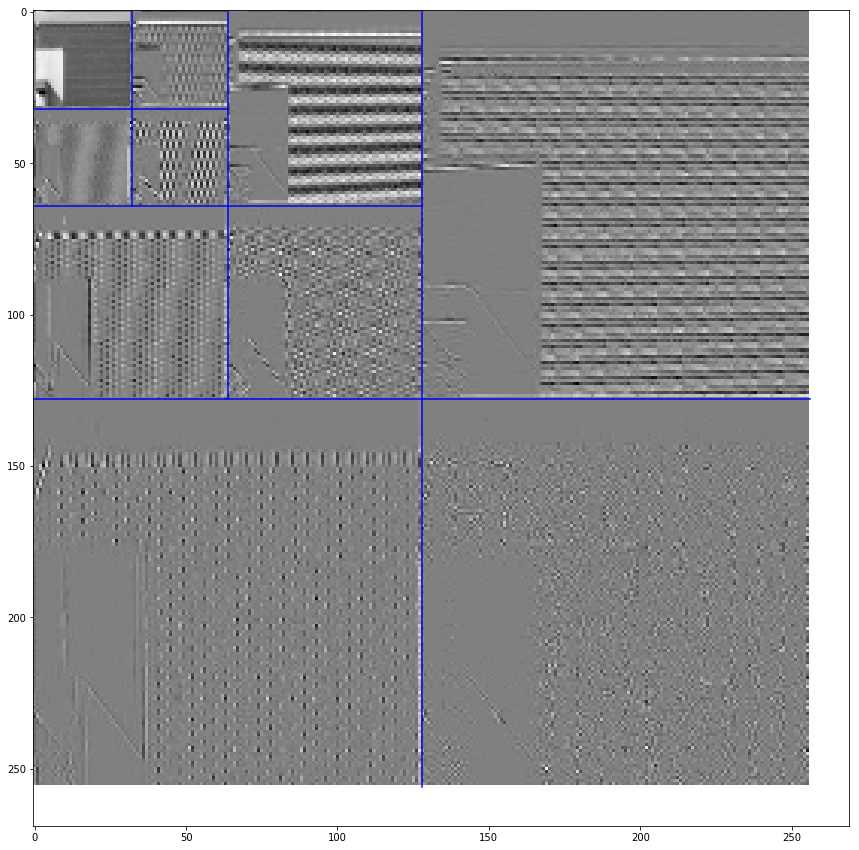

In [39]:
def rescale(f,a=0,b=1):
    ## function that rescale f between a and b.
    rang = f.max() - f.min()
    g = (f - f.min()).copy()
    if rang > 0:
        g = g / rang
    return a + g*(b-a)

def rescaleWav(A):
    ## function dedicated to a proper rescale of wavelet representation (particular case of the previous one).
    sup = abs(A).max()
    B = A.copy()
    if sup > 0:
        B = .5 + .5 * A / sup
    return B
    
def PlotWavelet(wavelet, iterations=1):
    ## Plot the wavelet representation, need to specify the number of iterations (or scales at which the FWT is computed).
    n = wavelet.shape[1]
    Jmax = int(np.log2(n)) - 1
    Jmin = Jmax - iterations + 1
    
    U = wavelet.copy()
    for j in np.arange(Jmax, Jmin - 1, -1):
        U[:2 ** j:,    2 ** j:2 **
            (j + 1):] = rescaleWav(U[:2 ** j:, 2 ** j:2 ** (j + 1):])
        U[2 ** j:2 ** (j + 1):, :2 **
          j:] = rescaleWav(U[2 ** j:2 ** (j + 1):, :2 ** j:])
        U[2 ** j:2 ** (j + 1):, 2 ** j:2 ** (j + 1):] = (
            rescaleWav(U[2 ** j:2 ** (j + 1):, 2 ** j:2 ** (j + 1):]))
    # coarse scale
    U[:2 ** j:, :2 ** j:] = rescale(U[:2 ** j:, :2 ** j:])
    # plot underlying image
    plt.figure(figsize=(15, 15))
    plt.imshow(U)
    # display crosses
    for j in np.arange(Jmax, Jmin - 1, -1):
        plt.plot([0, 2 ** (j + 1)], [2 ** j, 2 ** j], 'b')
        plt.plot([2 ** j, 2 ** j], [0, 2 ** (j + 1)], 'b')
    return U

PlotWavelet(Wt, it)

## Links
### Jpeg 2000
- https://www2.ulb.ac.be/cours/acohen/travaux_2006_infodoc/CompressionNumerique/TypeDonneesImageJPEG2000.htm
- https://www2.ulb.ac.be/cours/acohen/travaux_2006_infodoc/CompressionNumerique/TypeDonneesImageJPEG.htm#Le_JPEG

### RGB to YUV
- https://stackoverflow.com/questions/17892346/how-to-convert-rgb-yuv-rgb-both-ways
- https://fr.wikipedia.org/wiki/YUV

### Quantization
- https://www.whydomath.org/node/wavlets/jpeg2000quantization.html

In [ ]:
\tau = 2^{8-8.5+3}\left( 1 + 8/2^{11}\right) = 2^{2.5}\cdot 1.00390625 \approx 5.678951
